This noteboook defines and trains a neural-network (NN) model to fit the ice velocities values, where the vectori quantities for the wind and ice velocities are expressed in polar coordinates. The motivation behind this is the possible correlation observed between the variables h_piomas and the magnitude of the ice velocity (see Feature_engineering_and_analysis.ipynb)

The input of the model are : 
 - the two-dimensional wind velocity in polar EASE grid-coordinates, <b> wind_mag,wind_dir </b>
 - the x and y EASE positions in EASE grid-coordinates, <b> x_EASE,y_EASE</b> 
 - the sea-ice concentration in percentage, <b>sic_CDR</b>
 - the sea-ice thickness in m, <b>h_piomas</b>
 - the day of the year ranging from 1 to 364, <b>doy</b>
 - the year, <b>year</b>
 - the distance to coast in m, <b>d2c</b>

The output of the models are:
 - the two-dimensional ice velocities in polar EASE grid-coordinates, <b>ice_mag,ice_dir</b>

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle
import math

## Prepare the data

In [12]:
namefile = "DRIFT_DATA_TRAIN.csv"
df = pd.read_csv(namefile)

In [13]:
df['ice_mag'] = np.sqrt(df['u_buoy']**2 + df['v_buoy']**2 )
df['ice_dir'] = np.where(df['v_buoy']!= 0, np.arctan2(df['v_buoy'],df['u_buoy']), 0)
df['wind_mag'] = np.sqrt(df['u_ERA5']**2 + df['v_ERA5']**2 )
df['wind_dir'] = np.where(df['v_ERA5']!= 0, np.arctan2(df['v_ERA5'],df['u_ERA5']), 0)

In [14]:
df.head(5)

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c,ice_mag,ice_dir,wind_mag,wind_dir
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298,1.370671,2.191824,6.711849,-3.093710
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669,0.741408,0.520564,6.851881,-3.043036
2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,-8.825469,1.123955,0.996022,NaN,2.474106,362.547379,1.187695,2.934923,8.896751,3.014921
3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,-1.079951,-1.035410,0.982681,NaN,3.740522,381.025629,0.920127,0.028026,1.496117,-2.377247
4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,-2.169171,2.537787,0.990302,NaN,3.188522,521.535334,1.300527,1.273525,3.338513,2.278041


In [15]:
# Preparing the model features
# model with 9 inputs  : "u_ERA5","v_ERA5","x_EASE","y_EASE","sic_CDR","h_piomas","year","doy","d2c"
#            2 outputs : "ice_mag","ice_dir"
x = np.array(df[["wind_mag","wind_dir","x_EASE","y_EASE","sic_CDR","h_piomas","year","doy","d2c"]])
y = np.array(df[["ice_mag","ice_dir"]])

# Shuffle the data and divide them in train / test (using 80% / 20% distribution)
x, y = shuffle(x, y)
x_train = x[:271600]
y_train = y[:271600]
x_test = x[271600:]
y_test = y[271600:]

# Rescale the input features using the full dataset ( !!!! mean and variances need to be kept for predictions !!!! )
mean_x = np.mean(x,axis=0)
variances_x = np.var(x,axis=0)
x_train_norm = (x_train - mean_x)/variances_x
x_test_norm = (x_test - mean_x)/variances_x

## NN model definition

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,input_shape=[9],activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 34        
Total params: 12,178
Trainable params: 12,178
Non-trainable params: 0
_________________________________________________________________


## Running the model

In [17]:
# Run the model, need to specifiy what is the optimizer used
model.compile(loss="mse", optimizer='adam')
logs_model = model.fit(x=x_train_norm,y=y_train, epochs=25,verbose=1)

Epoch 1/25
8488/8488 [==============================] - 15s 2ms/step - loss: 18.9050
Epoch 2/25
8488/8488 [==============================] - 13s 2ms/step - loss: 15.5610
Epoch 3/25
8488/8488 [==============================] - 13s 2ms/step - loss: 14.4098
Epoch 4/25
8488/8488 [==============================] - 13s 2ms/step - loss: 13.8958
Epoch 5/25
8488/8488 [==============================] - 13s 2ms/step - loss: 13.7024
Epoch 6/25
8488/8488 [==============================] - 13s 2ms/step - loss: 13.4631
Epoch 7/25
8488/8488 [==============================] - 13s 2ms/step - loss: 13.2571
Epoch 8/25
8488/8488 [==============================] - 13s 2ms/step - loss: 13.0413
Epoch 9/25
8488/8488 [==============================] - 14s 2ms/step - loss: 13.0136
Epoch 10/25
8488/8488 [==============================] - 13s 2ms/step - loss: 12.8588
Epoch 11/25
8488/8488 [==============================] - 14s 2ms/step - loss: 12.8371
Epoch 12/25
8488/8488 [==============================] - 13s 2m

In [18]:
# Save the model for future uses !
model.save('model_2_op.h5')

## Predicting the MSE

In [23]:
# Compute predictions from the model both on train and test sets using the new parameterisation
y_predict_train = model.predict(x_train_norm)
y_predict_test = model.predict(x_test_norm)

print("The MSE on the modified train data set is equal to : ",mse(y_predict_train,y_train))
print("The MSE on the modified test data set is equal to : ",mse(y_predict_test,y_test))

The MSE on the modified train data set is equal to :  31.239649471119975
The MSE on the modified test data set is equal to :  31.144778908889045


In [24]:
# Compute predictions from the model both on train and test sets using the old parameterisation. 
# This gives us the opportunity to compare this model with the ones with the original parameterisation
y_orig_predict_train = np.array([[x*np.cos(y),x*np.sin(y)] for x,y in y_predict_train])
y_orig_true_train = np.array([[x*np.cos(y),x*np.sin(y)] for x,y in y_train])
y_orig_predict_test = np.array([[x*np.cos(y),x*np.sin(y)] for x,y in y_predict_test])
y_orig_true_test = np.array([[x*np.cos(y),x*np.sin(y)] for x,y in y_test])

print("The MSE on the original train data set is equal to : ",mse(y_orig_predict_train,y_orig_true_train))
print("The MSE on the original test data set is equal to : ",mse(y_orig_predict_test,y_orig_true_test))

The MSE on the original train data set is equal to :  100.3245863908091
The MSE on the original test data set is equal to :  100.58905542655135


## Visual inspections of predictions

### New parameterisation

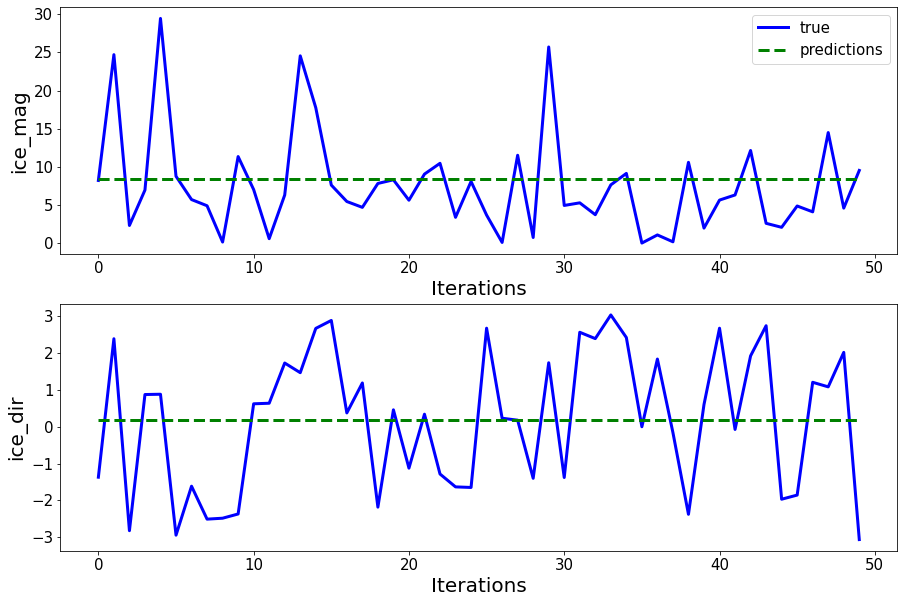

In [25]:
# Select the interval of poitns that you want to inspect (between 50 - 100 recommended)
beg = 0
end = 50

# Create matplotlib figure
fig, axes = plt.subplots(2, 1)

# Figure for u_buoy predictions
axes[0].plot(y_test.T[0][beg:end],linewidth = 3,label="true",color="b")
axes[0].plot(y_predict_test.T[0][beg:end],linewidth = 3,linestyle='dashed',label="predictions",color="g")
axes[0].legend(fontsize=15)
axes[0].set_xlabel("Iterations",fontsize=20)
axes[0].set_ylabel("ice_mag",fontsize=20)
axes[0].tick_params(labelsize=15)

# Figure for v_buoy predictions
axes[1].plot(y_test.T[1][beg:end],linewidth = 3,label="true",color="b")
axes[1].plot(y_predict_test.T[1][beg:end],linewidth = 3,linestyle='dashed',label="predictions",color="g")
axes[1].set_xlabel("Iterations",fontsize=20)
axes[1].set_ylabel("ice_dir",fontsize=20)
axes[1].tick_params(labelsize=15)

# change size figure
fig = plt.gcf()
fig.set_size_inches(15, 10)

### Original parameterisation

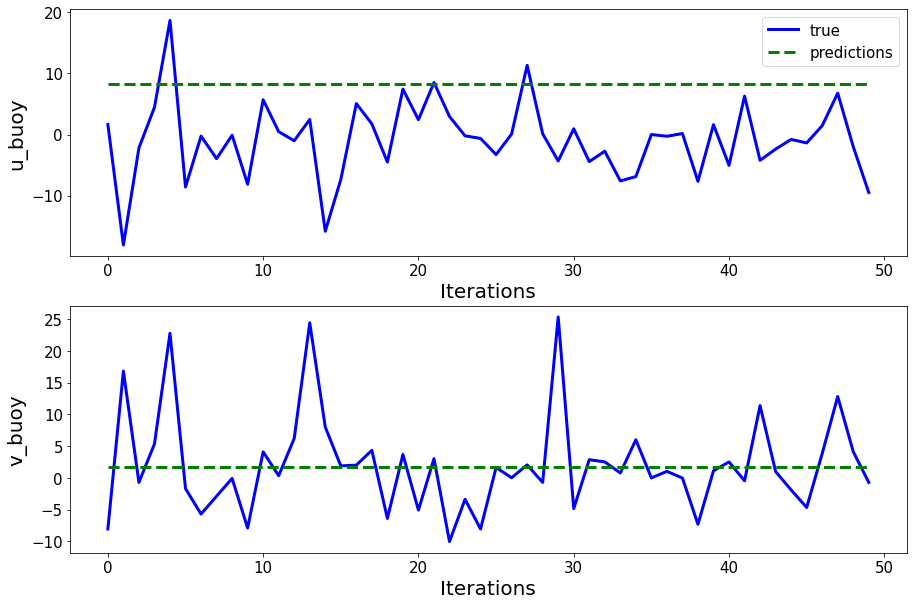

In [26]:
# Select the interval of poitns that you want to inspect (between 50 - 100 recommended)
beg = 0
end = 50

# Create matplotlib figure
fig, axes = plt.subplots(2, 1)

# Figure for u_buoy predictions
axes[0].plot(y_orig_true_test.T[0][beg:end],linewidth = 3,label="true",color="b")
axes[0].plot(y_orig_predict_test.T[0][beg:end],linewidth = 3,linestyle='dashed',label="predictions",color="g")
axes[0].legend(fontsize=15)
axes[0].set_xlabel("Iterations",fontsize=20)
axes[0].set_ylabel("u_buoy",fontsize=20)
axes[0].tick_params(labelsize=15)

# Figure for v_buoy predictions
axes[1].plot(y_orig_true_test.T[1][beg:end],linewidth = 3,label="true",color="b")
axes[1].plot(y_orig_predict_test.T[1][beg:end],linewidth = 3,linestyle='dashed',label="predictions",color="g")
axes[1].set_xlabel("Iterations",fontsize=20)
axes[1].set_ylabel("v_buoy",fontsize=20)
axes[1].tick_params(labelsize=15)

# change size figure
fig = plt.gcf()
fig.set_size_inches(15, 10)